In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gensim,jieba,os


In [2]:
df = pd.read_csv('cleandemo8.csv')
# del df['Unnamed: 0']
df.head(2)

,sessionid,request,response
0,13410000258T16081911402229APP,实名制了怎么还不能打电话？,请问是本机吗？我帮您开机，请稍等哈
1,13410000422T16082318212113APP,查询我现在的套餐,，您改了38元4G飞享套餐，9-13号生效哦，还在线吗，还有其他可以帮到您吗？


for sentences:
    sentence.cut()
    looking_up-> vec
kmeans or lda
GRU

# 读入词向量，对句子进行表示

In [3]:
from gensim.models import Word2Vec
# w = Word2Vec.load('./mymodel_pub')
# w = gensim.models.KeyedVectors.load_word2vec_format('./news_12g_baidubaike_20g_novel_90g_embedding_64.bin',binary=True)
w =  Word2Vec.load('./self_train_word2vec')

In [4]:
sens_vec = []
black = np.array([0]*w['话费'].shape[0])
for sen in df.response:
    sen = [vec for vec in jieba.cut(sen)]
    sen_array = [w[i] if i in w else black for i in sen]
    sens_vec.append(sum(sen_array)/float(len(sen_array)))
    


/Users/lucas/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/ny/f3f_tg0j5pl8mzvdvjd8258c0000gn/T/jieba.cache
Loading model cost 0.755 seconds.
Prefix dict has been built succesfully.
/Users/lucas/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/Users/lucas/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


# 聚类方法比较

### 降维，对聚类更友好

In [5]:
sens_vec
from sklearn.decomposition import PCA
pca = PCA(n_components=40)
sens_vec = pca.fit_transform(sens_vec)

In [6]:
sum(pca.explained_variance_ratio_)

0.9961375133455086

In [7]:
from sklearn.cluster import KMeans,DBSCAN,AgglomerativeClustering
# kmeans
k = 7
clf = KMeans(n_clusters=k) #设定k，这里就是调用KMeans算法 
s = clf.fit(sens_vec) #加载数据集合 

# dbscan
# clf = DBSCAN(eps=1.27, min_samples=20)
# clf.fit(sens_vec)

# AgglomerativeClustering
# clf = AgglomerativeClustering(n_clusters=7)
# clf.fit(sens_vec)

numSamples = len(sens_vec) 
centroids = clf.labels_
# print(centroids) #显示中心点
# print(clf.inertia_)  #显示聚类效果
# print(clf.cluster_centers_) #簇的中心向量
pd.DataFrame(list(clf.labels_))[0].value_counts()

4    1509
1    1282
5     951
6     673
0     619
3     603
2     495
Name: 0, dtype: int64

In [8]:
df_cluster = pd.concat((df,pd.DataFrame(clf.labels_,columns = ['cluster'])),axis = 1)
print(df_cluster.shape)
df_cluster.head()

(6132, 4)


,sessionid,request,response,cluster
0,13410000258T16081911402229APP,实名制了怎么还不能打电话？,请问是本机吗？我帮您开机，请稍等哈,5
1,13410000422T16082318212113APP,查询我现在的套餐,，您改了38元4G飞享套餐，9-13号生效哦，还在线吗，还有其他可以帮到您吗？,4
2,13410001228T160803125048,我前天办的飞享套餐，我要取消38元的,，请问是在什么时候办理的呢,5
3,13410001228T160803125048,电话办理的,您是不是之前要求取消了呢？,5
4,13410001228T160803125048,是的，我要求取消的昨天你们客服打电话来，我没接到,显示订单回退了，就是承诺使用38元套餐2个月的那个订单,2


In [9]:
df_cluster.to_csv('./df_cluster',index=False)

In [10]:
df_cluster[df_cluster.cluster ==0][:6]

,sessionid,request,response,cluster
18,13410002381T16082411455718APP,0元劲享30G流量包,，本机可承诺连续12个月使用88或以上4G套餐不改低，充值后用100元购买流量年包的，每月送...,0
24,13410002616T16082008352093APP,好的，非常感谢好滴，我给你发短信收费不,已为您成功办理手机流量30元套餐（2016）不用的啊,0
26,13410006681T160808172432,我想问下4g套餐升级送话费吗,有升级套餐预存话费送话费的活动,0
27,13410006681T160808172432,我想把套餐升级 现在不是18一个月的吗我想换成38那个,2016年7月1日-8月31日，已实名无合约、合约三个月内到期且无套餐或者升档套餐全球通\预...,0
32,13410006941T16081915080041APP,你好，我今天刚充值了100块钱话费，申请办理一年15G的流量赠送,2016年7月1日-8月31日期间，深圳移动受邀客户办理360元流量年包承诺连续12个月使用...,0
33,13410006941T16081915080041APP,但是怎么刚刚查话费就剩了8块钱我本来一直使用的是58元的套餐，然后你们不是0元申请吗,，这是用80元买价值360元的年包活动，送15个月的流量的,0


In [11]:
df_cluster.groupby('cluster').count()

,sessionid,request,response
cluster,,,
0,619,619,619
1,1282,1282,1282
2,495,495,495
3,603,603,603
4,1509,1509,1509
5,951,951,951
6,673,673,673


# 挑选合适的K

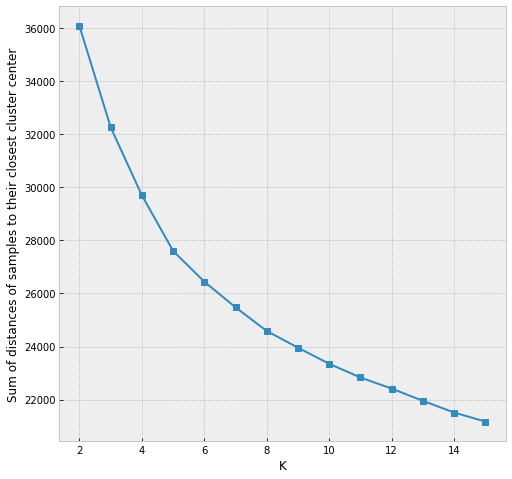

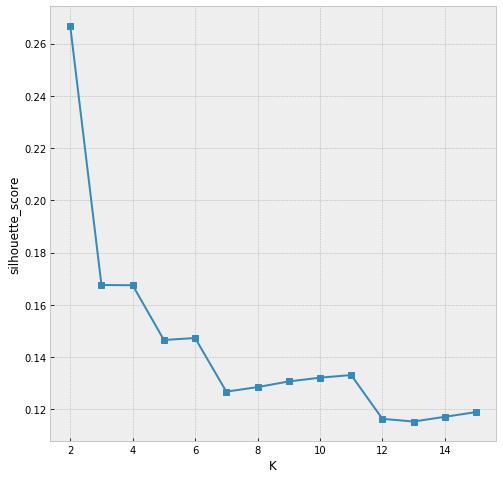

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
score = []
silhouette = []
k=15
for i in range(2,k+1):
    kmeas = KMeans(n_clusters =i,init="random").fit(sens_vec)
    
    silhouette.append(silhouette_score(sens_vec, kmeas.labels_, metric='euclidean'))
    score.append(kmeas.inertia_)

i = plt.figure(1)
plt.style.use('bmh')
plt.figure(figsize=(8,8))
plt.xlabel('K')
plt.ylabel('Sum of distances of samples to their closest cluster center')
plt.plot(range(2,k+1),score,marker ='s')
s=plt.figure(2)
plt.style.use('bmh')
plt.figure(figsize=(8,8))
plt.xlabel('K')
plt.ylabel('silhouette_score')
plt.plot(range(2,k+1),silhouette, marker = 's')
plt.show()



# 衡量ground truth

In [13]:
df_labeled = pd.read_csv('./data_labeled_2.csv')
print(df_labeled.shape)
df_labeled.head(2)

(93, 5)


,index,sessionid,request,domain,intention
0,227,13410022560T160817102657,你好，能帮我开通国际漫游吗,漫游,漫游办理
1,516,13410061331T16082619274909APP,所以我的号每个月都要扣多少钱呢,通话,话费查询


In [14]:
df_labeled.groupby('domain').count()

,index,sessionid,request,intention
domain,,,,
业务,3,3,3,3
套餐,30,30,30,30
宽带,2,2,2,2
流量,40,40,40,40
漫游,3,3,3,3
积分,2,2,2,2
通话,13,13,13,13


In [15]:
df_cluster_labeled = pd.merge(df_cluster,df_labeled)
df_cluster_labeled = df_cluster_labeled[df_cluster_labeled.cluster != -1]
print(df_cluster_labeled.shape)
df_cluster_labeled.head(3)

(65, 7)


,sessionid,request,response,cluster,index,domain,intention
0,13410000422T16082318212113APP,查询我现在的套餐,，您改了38元4G飞享套餐，9-13号生效哦，还在线吗，还有其他可以帮到您吗？,4,1,套餐,套餐查询
1,13410001228T160807211011,流量不清零的介绍,流量不清零服务：所有包含流量并按月计费的主套餐（不含4G随心王）、手机流量套餐、闲时套餐，当...,6,17,流量,流量介绍
2,13410001228T160807211011,能否帮我查下现在用的是不是六块月租的,，您现在是6元的月租的轻松卡的套餐的,2,19,套餐,套餐查询


## 评价指标 adjusted Rand index

In [16]:
df_cluster_labeled.domain.unique().shape[0]

6

In [17]:
df_cluster_labeled.groupby('domain').count()['index']

domain
业务     1
套餐    23
流量    30
漫游     2
积分     1
通话     8
Name: index, dtype: int64

In [18]:
# sklearn.metrics.homogeneity_score:每一个聚出的类仅包含一个类别的程度度量。
# sklearn.metrics.completeness:每一个类别被指向相同聚出的类的程度度量。
from sklearn import metrics
labels_true = df_cluster_labeled.domain
labels_pred = df_cluster_labeled.cluster
print(metrics.adjusted_rand_score(labels_true, labels_pred)  )
print(metrics.homogeneity_score(labels_true, labels_pred)  )


0.052707306487190325
0.23774957568114985


### 聚类的id进行随机分配,其系数

In [19]:

labels_true = df_cluster_labeled.domain
# labels_pred = df_cluster_labeled.cluster.sample(n=df_cluster_labeled.shape[0])
labels_pred = df_cluster_labeled.domain.sample(n=df_cluster_labeled.shape[0])
print(metrics.adjusted_rand_score(labels_true, labels_pred)  )
print(metrics.homogeneity_score(labels_true, labels_pred)  )

0.020947106790235256
0.15284620995572007


In [20]:
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 0, 1, 1, 2]
metrics.adjusted_rand_score(labels_true, labels_pred)

0.7058823529411765

# 结果

In [32]:
df_cluster[df_cluster.cluster == 6][:20]

,sessionid,request,response,cluster
10,13410001228T160807211011,小和要火，上月抢到的流量什么时候送,从2015年9月25日起停止发展流量转赠业务，已办理业务的客户不受影响，取消业务后将不能再办...,6
11,13410001228T160807211011,流量不清零的介绍,流量不清零服务：所有包含流量并按月计费的主套餐（不含4G随心王）、手机流量套餐、闲时套餐，当...,6
19,13410002616T16082008352093APP,WLAN流量是什么,就是移动公众场所的WIFI,6
44,13410008121T160807120304,我说的是奥运流量包19元hello,只能尝试发送19元 发送KTAYLLB19至10086。办理,6
53,13410008884T16081619464102APP,通用流量还是定向流量呢是不是什么方面都可以用的呀,，不是的哦会员权益流量包的使用方法：央视咪咕视讯会员、新媒体会员客户可通过线上办理页面、短信...,6
57,13410011005T160808211517,我开的短号群怎么只有一个号码可以用呢,，您已进入人工服务，可直接输入文字提问，例如查询剩余流量……等等哦查询您目前只加了一个副号哦，,6
80,13410017729T160829205935,免费套餐介绍,移动公司暂未推出拨打电话免费的套餐，感谢您的关注。我公司现推出4G上网套餐，共包含58-88...,6
81,13410017729T160829205935,取消流量套餐,手机流量套餐取消方法：免费发QXLL或QXSJLL到10086，根据二次确认短信提示，1小时...,6
84,13410018328T160813203950,电信卡可以加家庭短号？,不可以家庭短号只能加广东省内的移动号码,6
85,13410018485T16080117224466APP,闲时流量使用时间,23：00-8:00还有什么可以帮到的呢？,6


In [22]:
df_cluster_labeled[df_cluster_labeled.cluster == 6][:10]

,sessionid,request,response,cluster,index,domain,intention
1,13410001228T160807211011,流量不清零的介绍,流量不清零服务：所有包含流量并按月计费的主套餐（不含4G随心王）、手机流量套餐、闲时套餐，当...,6,17,流量,流量介绍
4,13410002616T16082008352093APP,WLAN流量是什么,就是移动公众场所的WIFI,6,26,流量,流量介绍
16,13410061331T16082619274909APP,所以我的号每个月都要扣多少钱呢,外网短信通讯费 20160826 ￥1.35本地省际长途费 20160826 ￥1.17本地...,6,516,通话,话费查询
27,13410087471T160829145808,我的是深圳卡在广州沟通100可以办理换4G卡吗？,目前0元换4G卡暂只可通过沟通100营业厅办理，网站、“广东移动手机营业厅”APP等渠道暂停...,6,789,套餐,套餐办理
30,13410098426T16081108460441APP,办理特惠包怎么办呢你帮我办理是在线办理吗,办理特惠包需要验证密码，您通过短信进入在线，验证不了服务密码哦，爱的您只是办特惠包，没有收到...,6,836,流量,流量办理
37,13410116016T16081808223308APP,交话费，也是在支付宝怎么行？流量就不行了？,流量申请可以通过短信、移动官网或者人工办理哦！请不要通过第三方的途径办理，谢谢！,6,977,通话,话费充值


## 对labeled数据进行聚类

In [23]:
sens_vec_labeld = []
black = np.array([0]*w['套餐'].shape[0])
for sen in df_labeled.request:
    sen = [vec for vec in jieba.cut(sen)]
    sen_array = [w[i] if i in w else black for i in sen]
    sens_vec_labeld.append(sum(sen_array)/float(len(sen_array)))

/Users/lucas/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app
/Users/lucas/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/Users/lucas/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [24]:
df_cluster_labeled.groupby(['cluster','domain',]).count()

sessionid  request  response  index  intention
cluster domain                                                
0       套餐              3        3         3      3          3
        流量             10       10        10     10         10
        通话              1        1         1      1          1
1       业务              1        1         1      1          1
        套餐              2        2         2      2          2
        流量              7        7         7      7          7
        积分              1        1         1      1          1
2       套餐              4        4         4      4          4
        流量              3        3         3      3          3
        通话              1        1         1      1          1
3       套餐              7        7         7      7          7
        流量              2        2         2      2          2
4       套餐              5        5         5      5          5
        流量              3        3         3      3          3
        通话              3        3         3      3          3
5       套餐              1        1         1      1          1
        流量              2        2         2      2          2
        漫游              2        2         2      2          2
        通话              1        1         1      1          1
6       套餐              1        1         1      1          1
        流量              3        3         3      3          3
        通话              2        2         2      2          2

```python
def cluster(feature_name, k):
    sens_vec = []
    black = np.array([0]*w['套餐'].shape[0])
    for sen in df.response:
        sen = [vec for vec in jieba.cut(sen)]
        sens_vec.append(sum([w[i] if i in w else black for i in sen]))
    clf = KMeans(n_clusters=k) #设定k，这里就是调用KMeans算法
    s = clf.fit(sens_vec) #加载数据集合
    df_cluster = pd.concat((df,pd.DataFrame(clf.labels_,columns = ['cluster'])),axis = 1)
    return clf, df_cluster

clf_reponse, cluster_response = cluster('response', 30)
clf_request, cluster_request = cluster('request', 30)

fig,(ax0,ax1) = plt.subplots(nrows=2,figsize=(9,6)) 
ax0.hist(cluster_request.cluster,40,histtype='bar',facecolor='yellowgreen',alpha=0.75)
ax0.set_title('request')
ax1.hist(cluster_response.cluster,40,histtype='bar',facecolor='pink',alpha=0.75,) 
ax1.set_title("response") 
fig.subplots_adjust(hspace=0.4) 
plt.show()
```